# Histrogram Cloning and Detection

Ref: Anomaly Extraction and Backbon networks using association rules

Histogram cloning: to obtain additional traffic views the distribution of a traffic feature is tracked by multiple histogram clones

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime

from hashing import HashFunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
filename = '../datasets/2016-04-08_1000.csv'
df = pd.read_csv(filename)
df['te'] = pd.to_datetime(df['te'])

In [106]:
df.head()

,te,td,sa,da,sp,dp,pr,flg,fwd,stos,pkt,byt,type
0,2016-04-08 00:00:00,0.0,42.219.156.198,143.72.8.137,60602,53,UDP,.A....,0,0,1,82,background
1,2016-04-08 00:00:00,0.0,64.208.211.232,42.219.155.28,41282,443,TCP,...R..,0,8,1,40,background
2,2016-04-08 00:00:01,0.0,204.97.46.117,42.219.152.249,39710,53,UDP,.A....,0,0,1,88,background
3,2016-04-08 00:00:01,0.0,32.166.116.224,42.219.152.249,0,2816,ICMP,.A....,0,72,1,56,background
4,2016-04-08 00:00:01,0.0,42.219.156.211,67.205.239.149,443,58336,TCP,.A....,0,0,1,40,background


In [107]:
# Phase 1: Compute KL divergence of source IP
srcIPHasher = HashFunction(length=5)

[40, 177, 42, 52, 44, 26, 21, 42, 30, 37, 45, 32, 24, 36, 18, 25, 35, 24, 36, 17, 15, 21, 15, 27, 33, 58, 32, 42, 167, 34, 17, 20]


<BarContainer object of 32 artists>

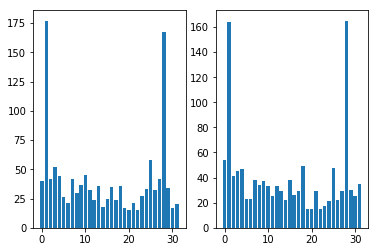

In [108]:
# get some 15 minute block
testWindow1 = df[df['te'] < pd.to_datetime('2016-04-08 00:15:00')]
testWindow2 = df[(df['te'] > pd.to_datetime('2016-04-08 00:15:00')) & 
                 (df['te'] < pd.to_datetime('2016-04-08 00:30:00'))]

def getHist(df_window):
    hist = [0 for i in range(srcIPHasher.nBins)]
    for _, row in df_window.iterrows():
        sa = row['sa']
        hist[srcIPHasher.hash(sa)] += 1
    return hist

hist1 = getHist(testWindow1)
hist2 = getHist(testWindow2)

print(hist1)
# plot them side by side
plt.figure(1)
plt.subplot(121)
plt.bar(range(srcIPHasher.nBins), hist1)
plt.subplot(122)
plt.bar(range(srcIPHasher.nBins), hist2)

In [109]:
def KL(hist2, hist1):
    '''
    new one is in the first param
    '''
    hist2 = [x if x else 1 for x in hist2]
    hist1 = [x if x else 1 for x in hist1]
    return entropy(hist2, hist1)

kl = KL(hist2, hist1)
print('KL between hist2 and hist1 is %s' % kl)

KL between hist2 and hist1 is 0.026501987877244573


In [110]:
# Plot the KL Divergence over the entire day
cols = ["te", "td", "sa", "da", "sp", "dp", "pr", "flg", "fwd", "stos", "pkt", "byt", "type"]

chunksize = 20000
window_start = None
window_end = None
windowLength = pd.Timedelta("%s minutes" % 15) # 15 minutes
df_window = None
df_window = pd.DataFrame(columns=cols)

kl_series = []
prev_hist = None
def process(time, df):
    global prev_hist
    
    hist = getHist(df)
    if prev_hist:
        kl = KL(hist, prev_hist)
        kl_series.append((time, kl))
    prev_hist = hist

for df in pd.read_csv(filename, chunksize=chunksize, iterator=True):
    df.columns = cols
    df['te'] = pd.to_datetime(df['te'])
    if window_start is None:
        t = df.loc[0]['te']
        window_start = datetime.datetime(t.year, t.month, t.day)
        window_end = window_start + windowLength
    df_curr_window = df[(window_start <= df['te']) & (df['te'] < window_end)]
    df_next = df[window_end <= df['te']]
    if df_curr_window.shape[0] == 0:
        break
    while df_next.shape[0]:
        df_window = df_window.append(df_curr_window)
        process(window_start, df_window)
        df_window = pd.DataFrame(columns=cols)
        window_start, window_end = window_end, window_end + windowLength

        df_curr_window = df[(window_start <= df['te']) & (df['te'] < window_end)]
        df_next = df[window_end <= df['te']]

    df_window = df_window.append(df_curr_window)
process(window_start, df_window)

kl_series = pd.DataFrame(data=[d[1] for d in kl_series], columns=['kl'], 
                         index=[d[0] for d in kl_series])

<StemContainer object of 3 artists>

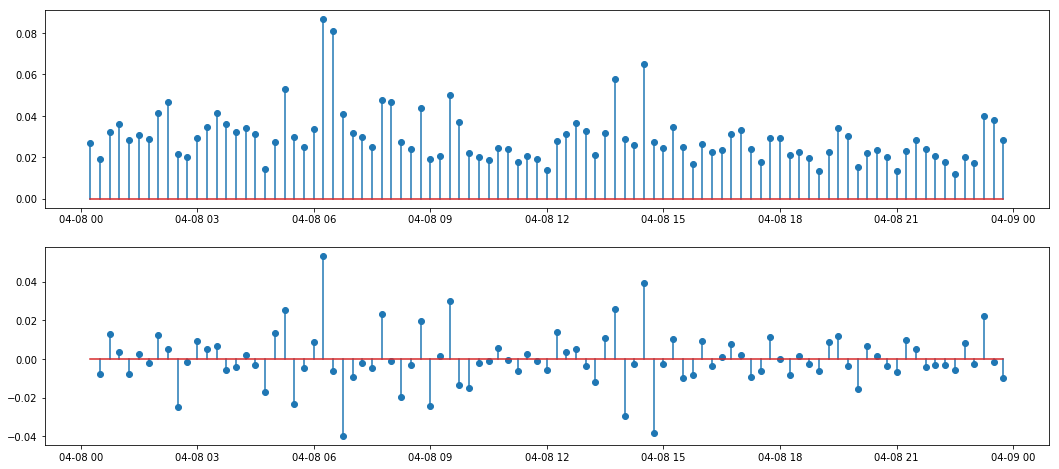

In [111]:
# plot kl and kl first difference
plt.figure(figsize=(18,8)) # w by h
plt.subplot(211)
plt.stem(kl_series.index, kl_series.kl)
plt.subplot(212)
kl_series_diff = kl_series.diff()
plt.stem(kl_series_diff.index, kl_series_diff.kl)